In [3]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from models.AdEx import NeuronModel
from result import Visualization

import subprocess
from IPython.display import display, Markdown
from simulation_runner import load_params, run_simulation

### Modeling Result

Converted parameters: {'k': 1, 'v': -80. * mvolt, 'u': 0. * volt / second, 'vr': -64.4 * mvolt, 'vt': -50. * mvolt, 'a': 200. * mhertz, 'b': 25. * mhertz, 'C': 80. * pfarad, 'd': 0. * volt / second, 'I': 100. * pamp}


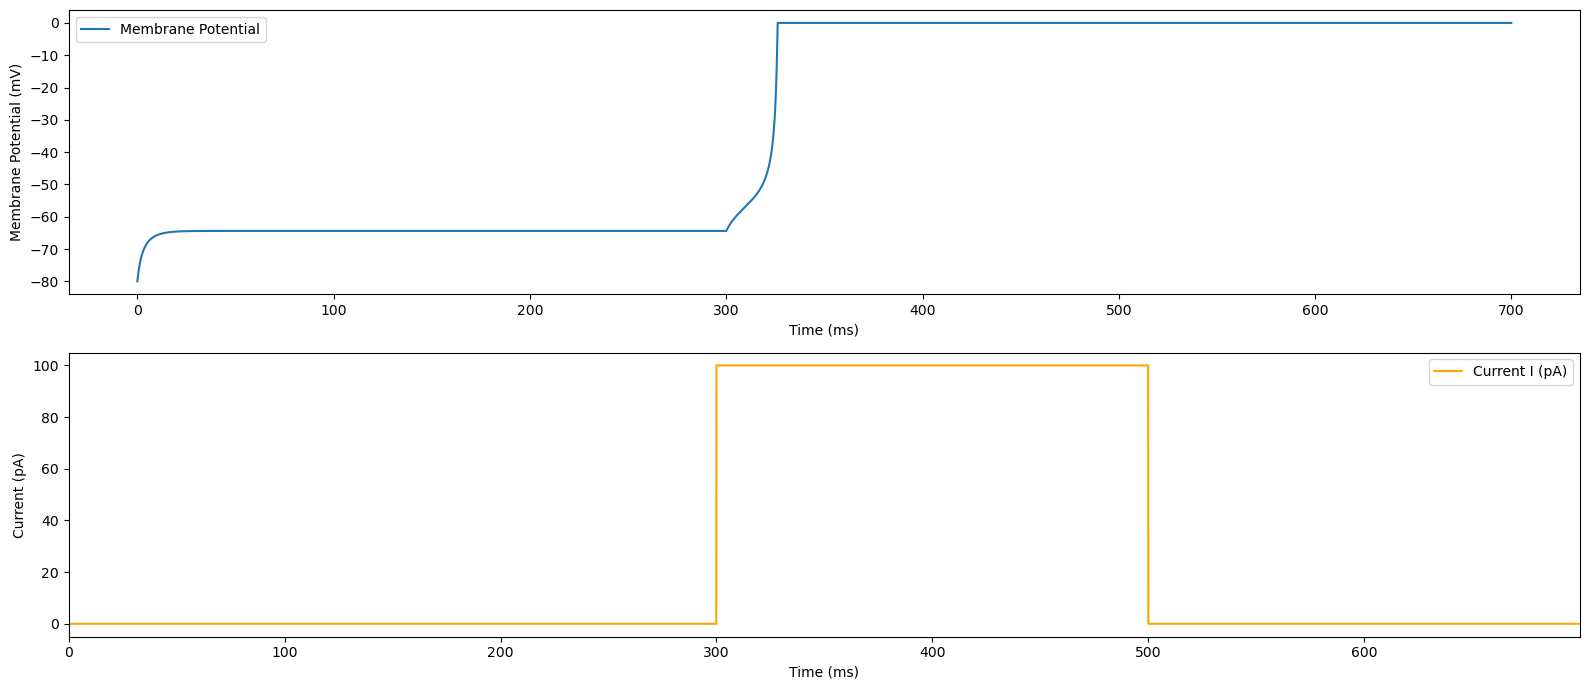

In [5]:
### Qudratic Integrate and Fire 
json_file = './params/QIF.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value'] 

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 10. * pamp}


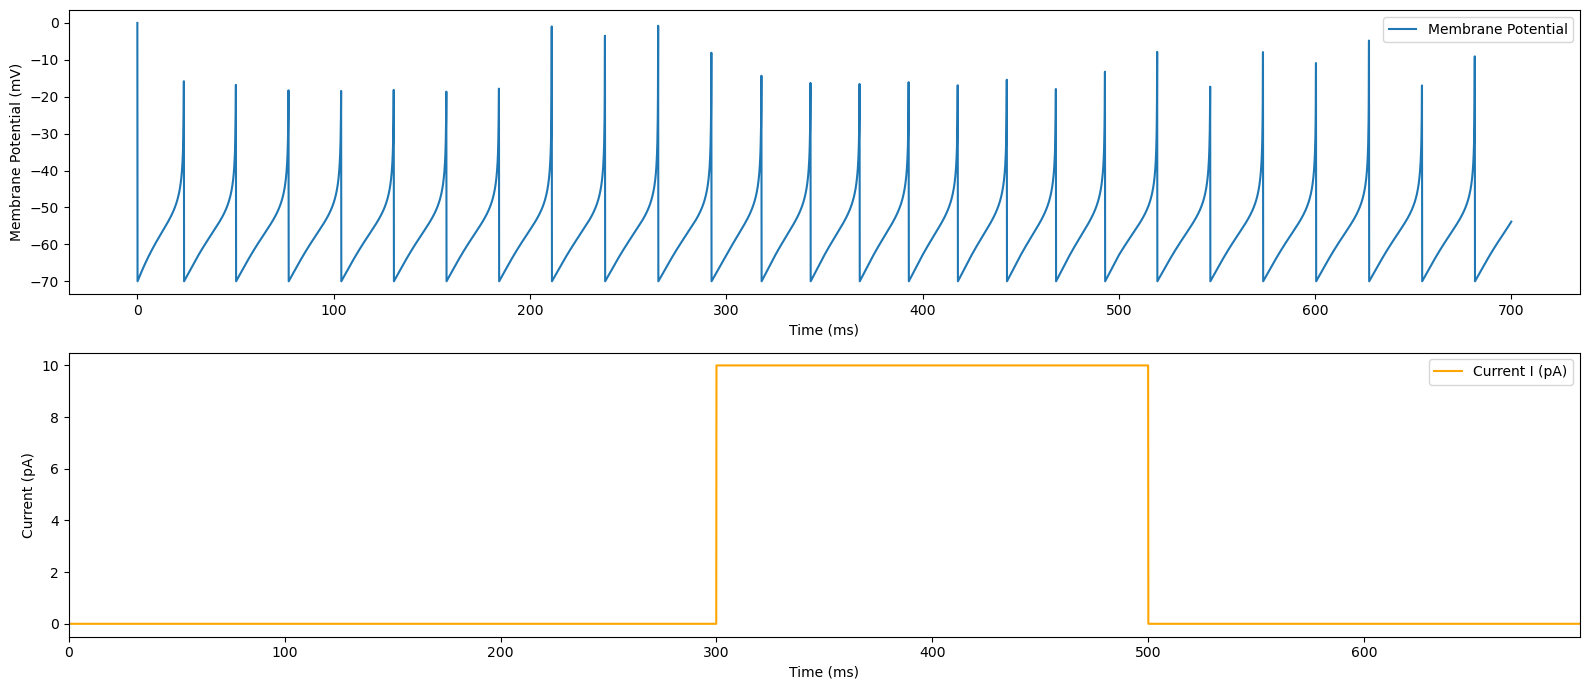

In [6]:
### Adaptive Exponential Integrate and Fire 
json_file = './params/AdEx.json'  

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

### AdEx spontaneous
- set I as 100pA

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'v': -58. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 100. * pamp}


INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh
INFO:root:arm64-apple-darwin20.0.0-clang -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-stron

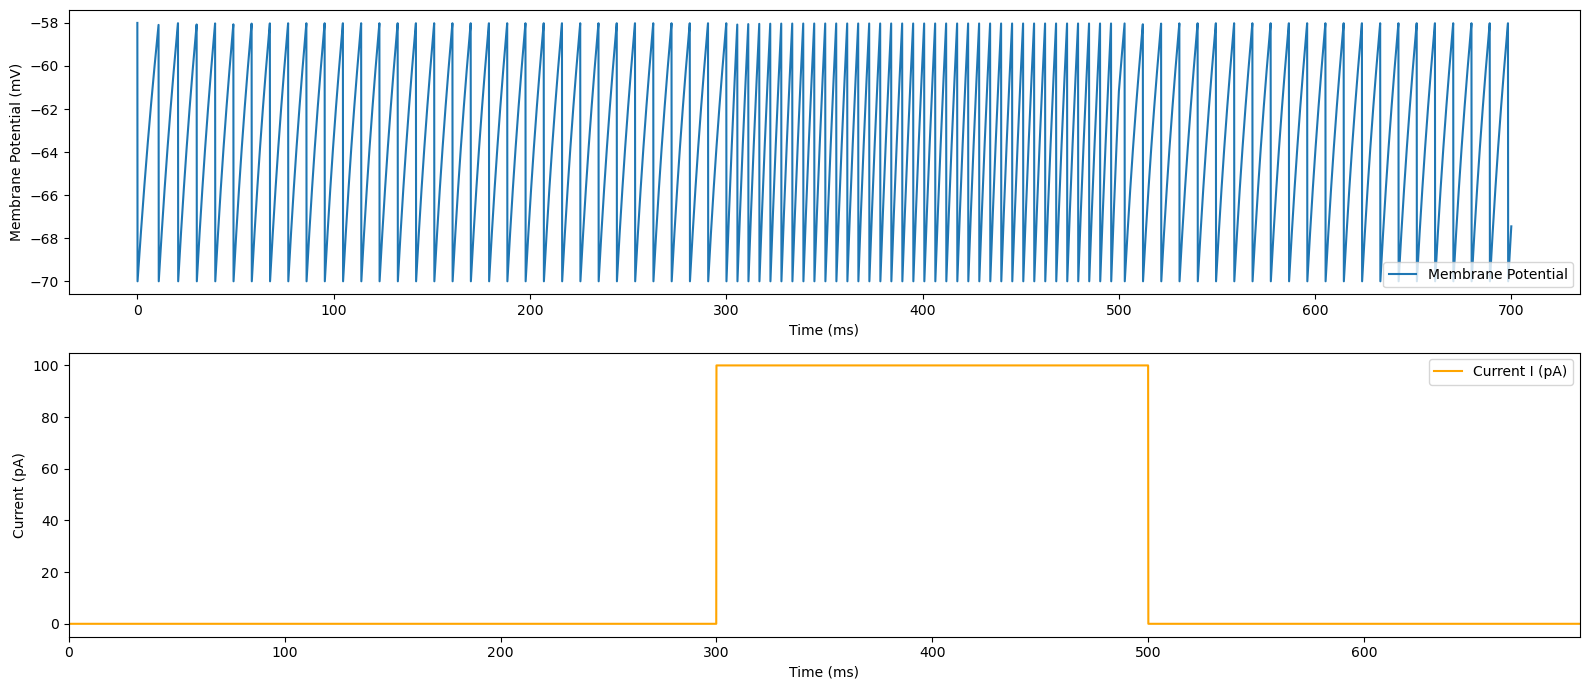

In [ ]:
### Adaptive Exponential Integrate and Fire (v = threshold)
json_file = './AdEx2.json'  

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'v': -10. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 100. * pamp}


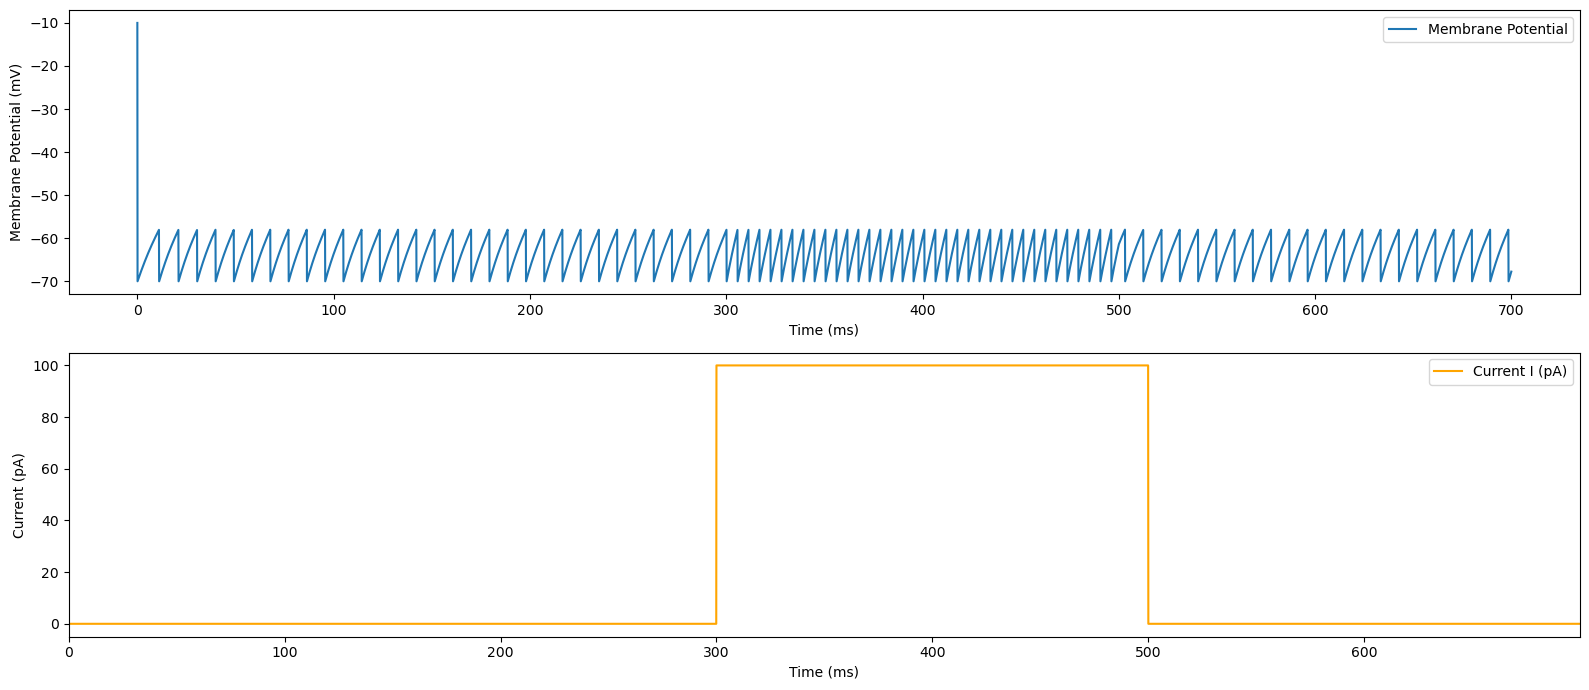

In [ ]:
### Adaptive Exponential Integrate and Fire (v > threshold)
json_file = './AdEx2.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'v': -100. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 100. * pamp}


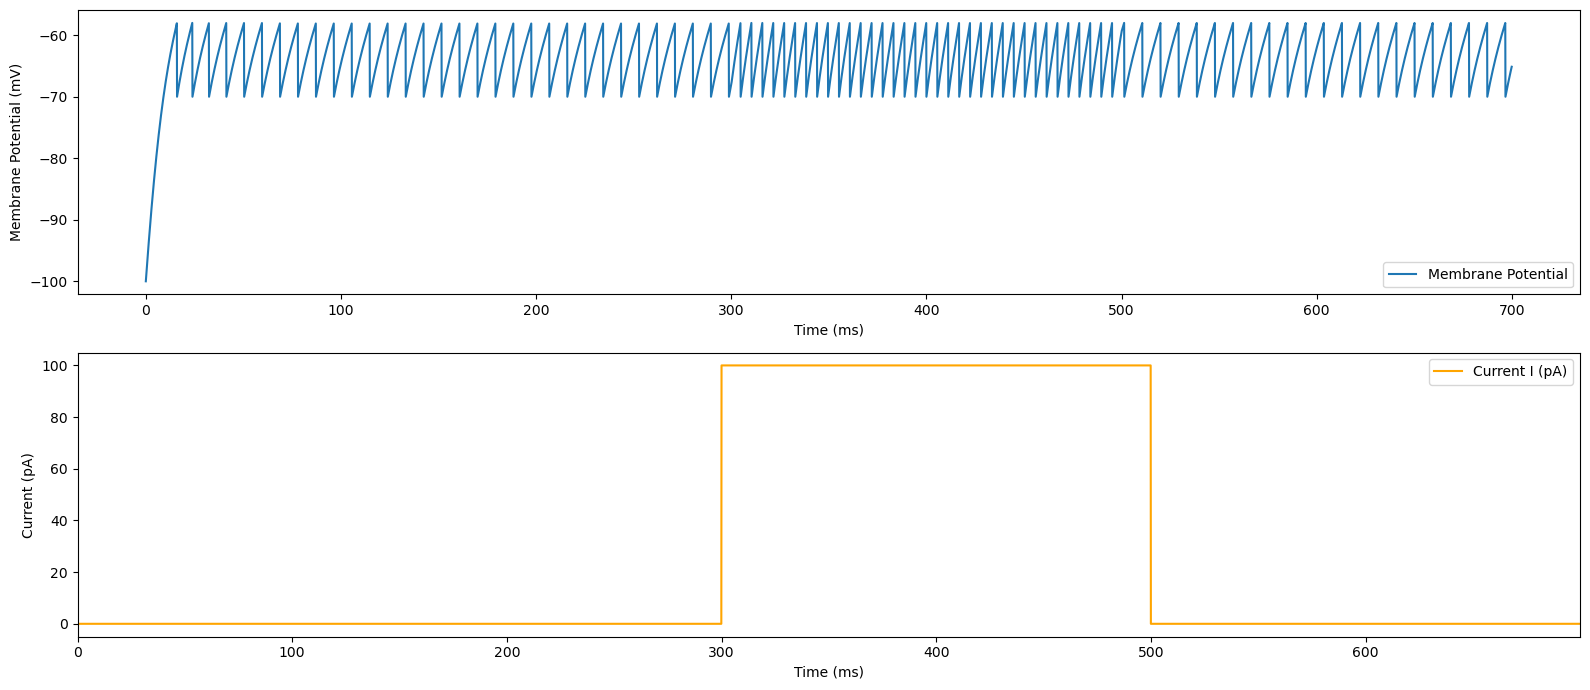

In [ ]:
### Adaptive Exponential Integrate and Fire (v < threshold)
json_file = './AdEx2.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

### Monitoring with different I

In [1]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from simulation_I import run_simulation, load_params, plot_results
from result_I import Run

INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_i3hlog3_/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_i3hlog3_/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_i3hlog3_/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_i3hlog3_/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_i3hlog3_/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_i3hlog3_/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_i3hlog3_
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

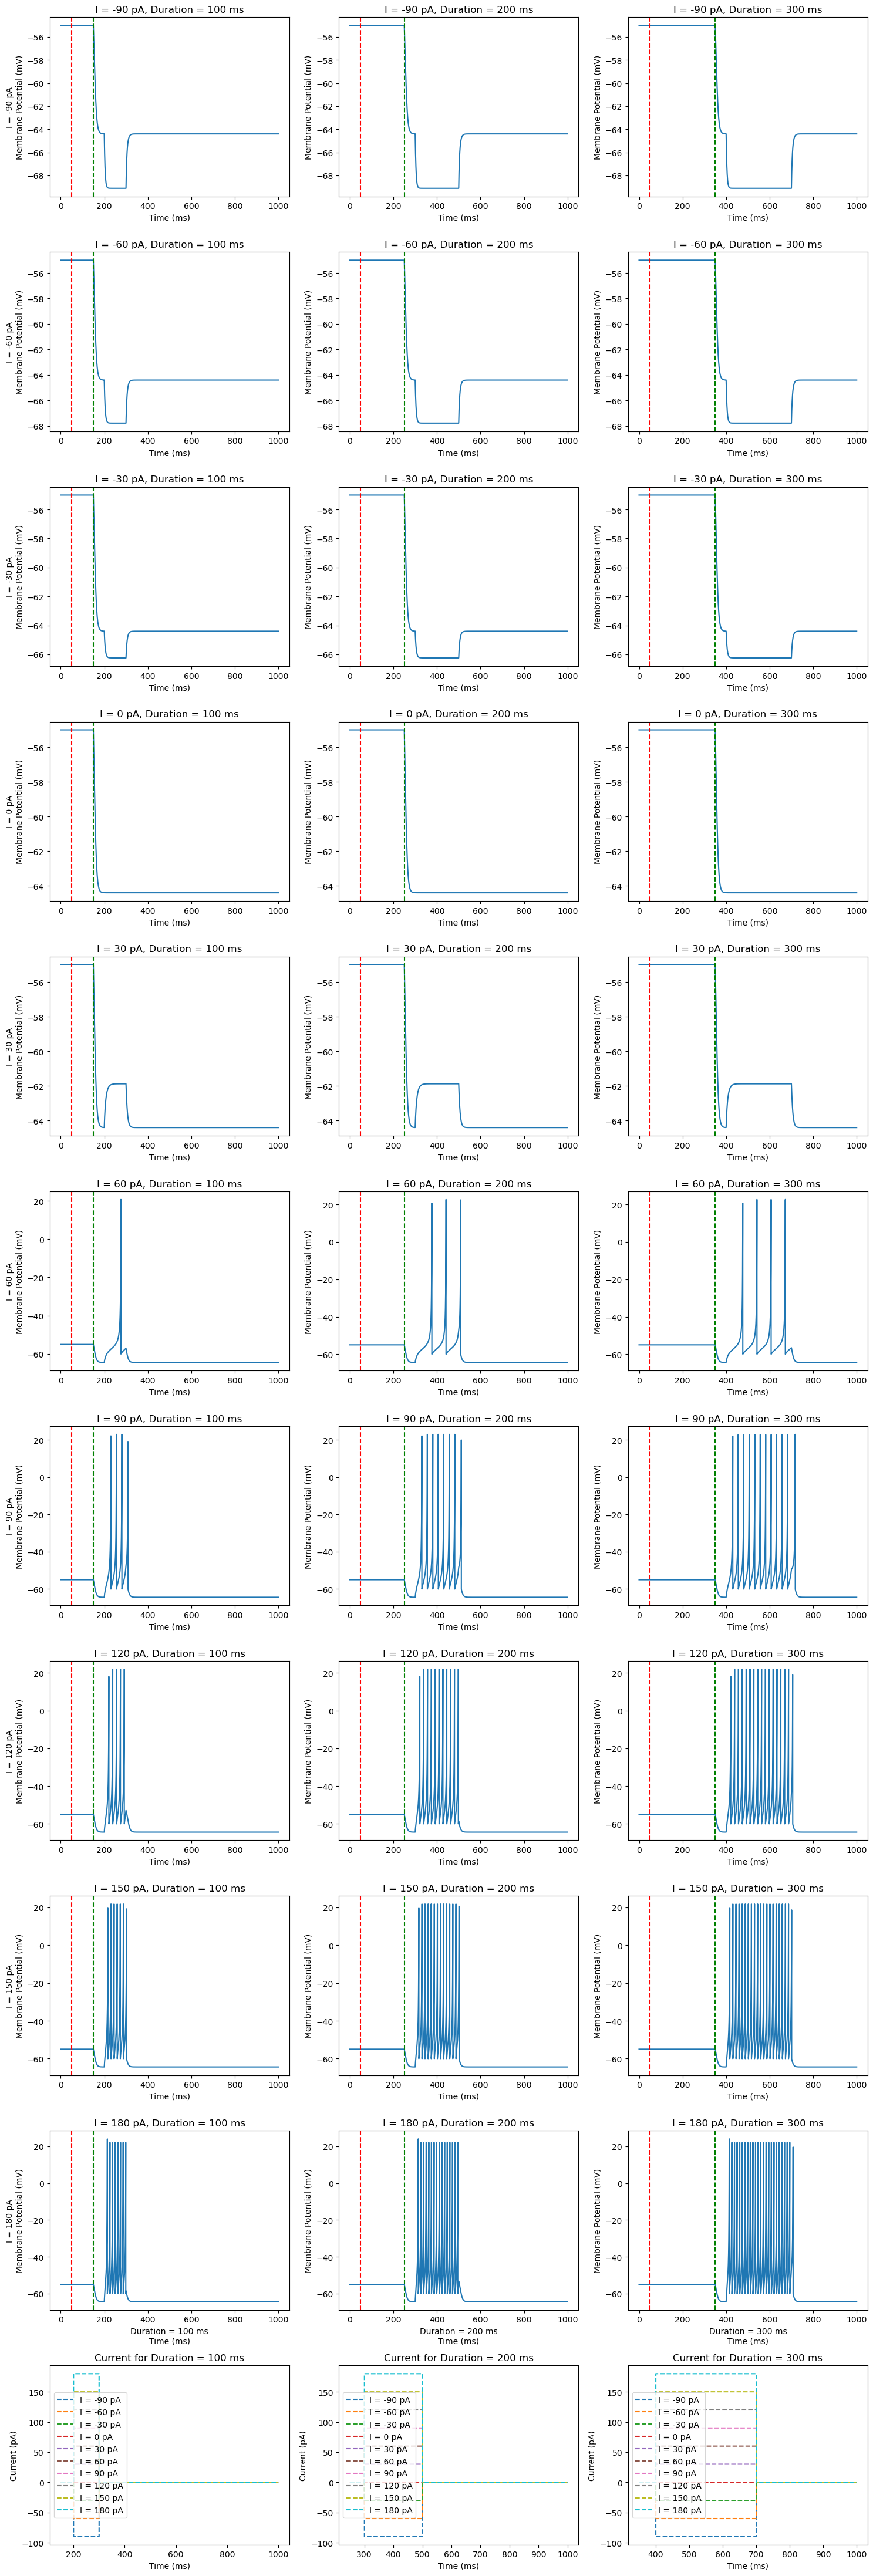

In [2]:
json_file = './params_ref/FSN_1.json'  

# Load parameters
params, model_name = load_params(json_file)

N = params.pop('N')['value']  
I_values = [-90, -60, -30, 0, 30, 60, 90, 120, 150, 180]
durations = [100, 200, 300]  # Example durations in ms

# Run simulation
all_results, all_currents, total_time, injection_times = run_simulation(N, params, model_name, I_values, durations)

# Plot results
plot_results(all_results, all_currents, I_values, total_time, injection_times, durations)

INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_9on7yi_4/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_9on7yi_4/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_9on7yi_4/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_9on7yi_4/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_9on7yi_4/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_9on7yi_4/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_9on7yi_4
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

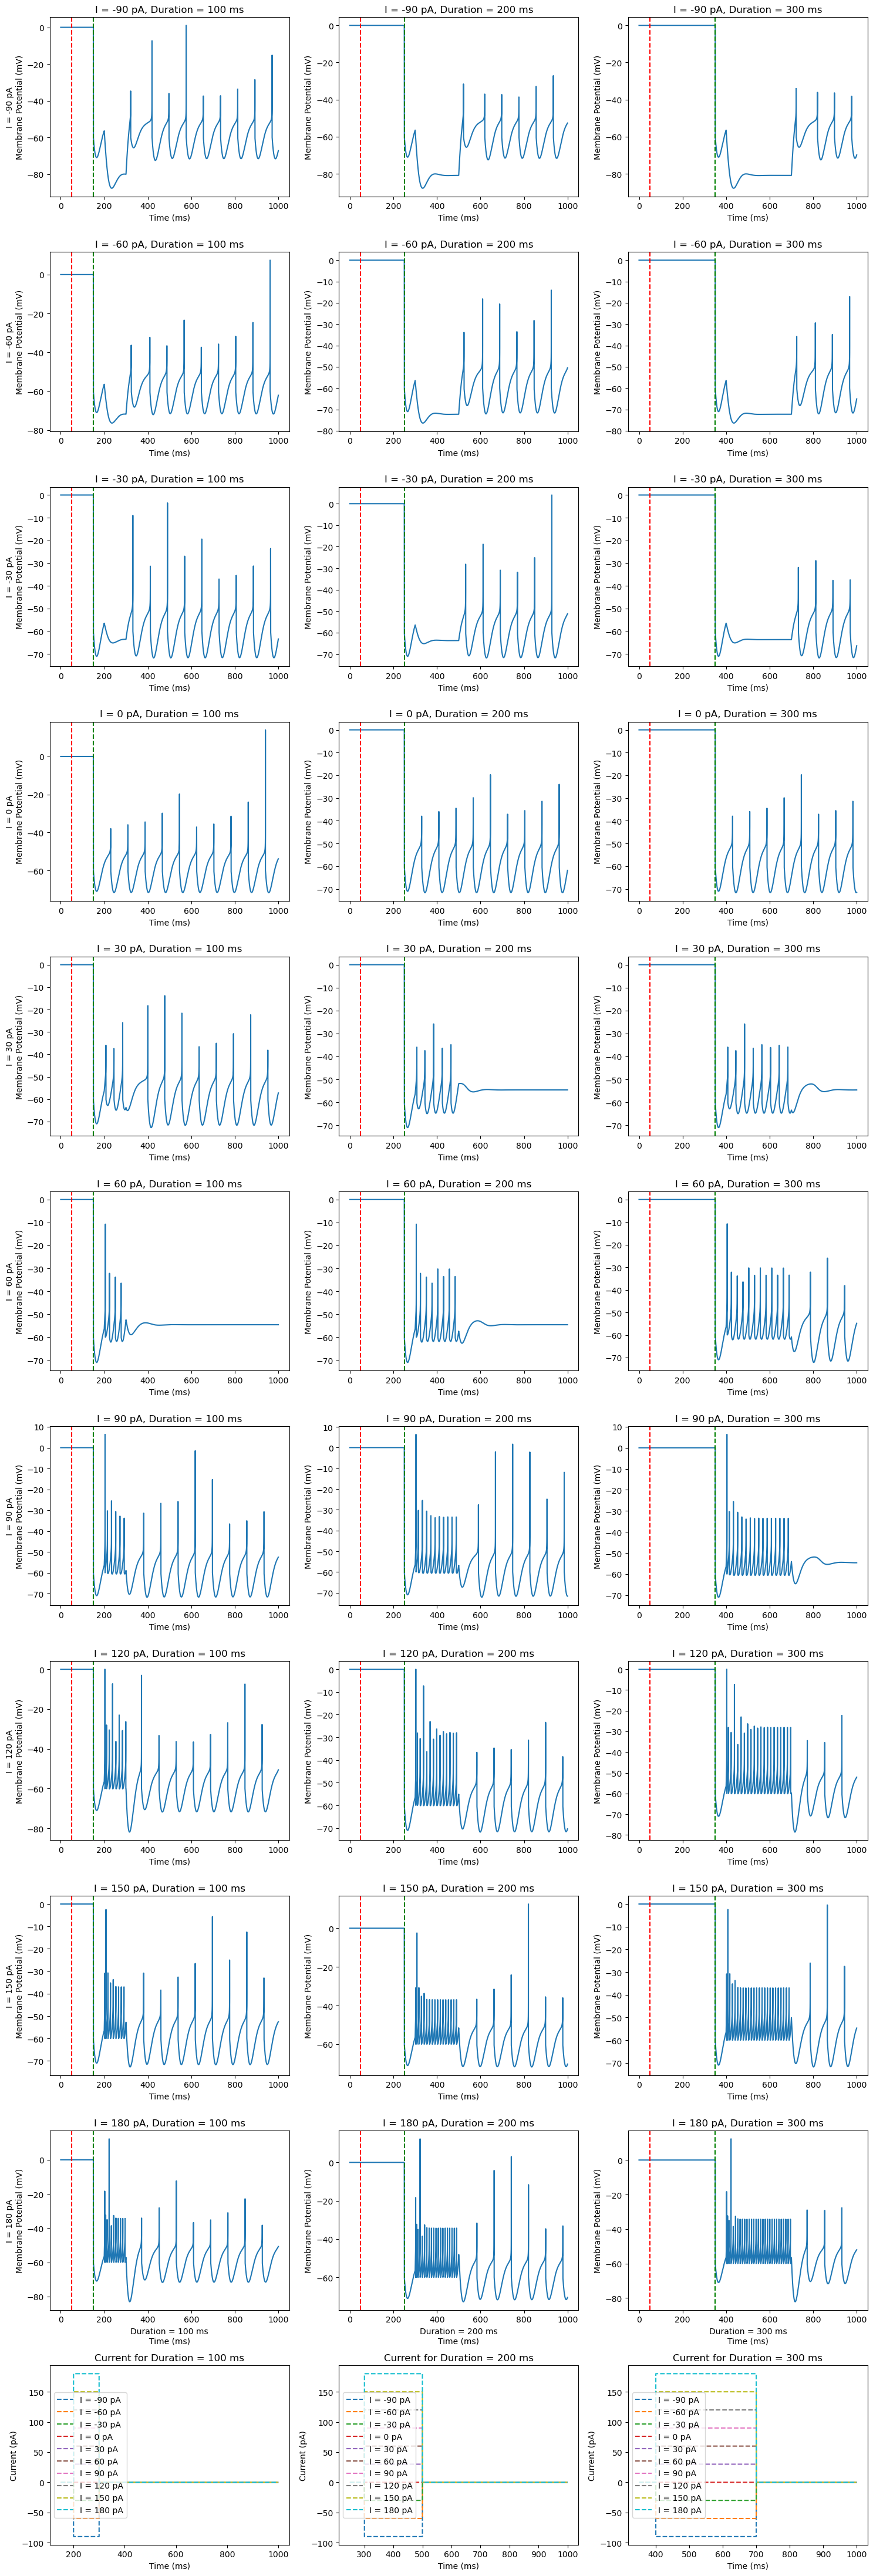

In [2]:
json_file = './params_ref/GPe_T1_1.json'  

# load parameters
params, model_name = load_params(json_file)

N = params.pop('N')['value']  
I_values = [-90, -60, -30, 0, 30, 60, 90, 120, 150, 180]
durations = [100, 200, 300]  # Example durations in ms

# Run simulation
all_results, all_currents, total_time, injection_times = run_simulation(N, params, model_name, I_values, durations)

# Plot results
plot_results(all_results, all_currents, I_values, total_time, injection_times, durations)